# Gray Scale Model

### Important Variables:

In this task we will be implementing the SIR model with the following system parameters:

*   $a_{i}(b)$: total amount of assets hold by user i by the end of block b.
*   $d_{i}(b)$: total amount of black assets hold by node i by the end of block b.
*   $x_{i}(b)$: = $\frac{d_{i}(b)}{a_{i}(b)} $ black assets fraction by the end of block b.
*   $c_{i}(b)$: amount of clean asset owned by node i by the end of block b
*   $m_{i}(b)$: the amount mined by user i by the end of block b
*   $W(b)$: = {$w_{ij}$}$_{i,j=1,...,N}$ is the adjacency matrix of the transaction network at block b. wij is equal to the amount of bitcoin moved from user i to user j at block b.
*   $N = Nusers = |Nusers|$ total number of users in the network.

Below is a summary of the dynamics of the SIR model:

In [4]:
import blocksci

import sys, os, os.path, socket
import numpy as np
import zarr
import time
import pandas as pd
from collections import defaultdict
from decimal import Decimal
import math
from datetime import datetime, timedelta
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.dates
import json
import networkx as nx

from util import SYMBOLS, DIR_BCHAIN, DIR_PARSED, SimpleChrono, darknet


def format_e(n):
    a = '%E' % n
    return a.split('E')[0].rstrip('0').rstrip('.') + 'E' + a.split('E')[1]

def daterange(date1, date2, by=1):
    return [  date1 + timedelta(n) for n in range(0, int((date2 - date1).days)+1, by) ]     

# Address Mapper Class

In [2]:
# this class creates a map from addresses to the set {0 -> number of cluster}, in other words it helps to use arrays to store the information. 
class AddressMapper(): # This creates the map that clusters the addresses to actual users. Treat it a a blackbox for now.
    def __init__(self, chain):
        self.chain = chain

        self.__address_types = [blocksci.address_type.nonstandard, blocksci.address_type.pubkey,
                                blocksci.address_type.pubkeyhash, blocksci.address_type.multisig_pubkey,
                                blocksci.address_type.scripthash, blocksci.address_type.multisig,
                                blocksci.address_type.nulldata, blocksci.address_type.witness_pubkeyhash,
                                blocksci.address_type.witness_scripthash, blocksci.address_type.witness_unknown]

        self.__counter_addresses = { _:self.chain.address_count(_) for _ in self.__address_types }

        self.__offsets = {}
        offset = 0
        for _ in self.__address_types:
            self.__offsets[_] = offset
            offset += self.__counter_addresses[_]


        self.total_addresses = offset
        print(f"[INFO] #addresses: {self.total_addresses}")
#        print(self.__counter_addresses)


    def map_clusters(self,cm):
#        address_vector = {_: np.zeros(self.__counter_addresses[_], dtype=np.int64) for _ in self.__address_types }
        cluster_vector = {_: np.zeros(self.__counter_addresses[_], dtype=np.int64) for _ in self.__address_types }

        self.cluster = np.zeros(self.total_addresses, dtype=np.int64)
        offset = 0
        for _at in cluster_vector.keys():
            clusters = cluster_vector[_at]
            print(f"{_at}     -  {len(clusters)}")
#            addrs = address_vector[_at]
            for _i, _add in enumerate(chain.addresses(_at)):
#                addrs[_i] = _add.address_num
                clusters[_i] = cm.cluster_with_address(_add).index
                #max_addr_num = max(max_addr_num, addrs[_i])
#        pickle.dump(cluster_vector, open("cluster_dict.pickle","wb"))

        offset = 0
        for _ in cluster_vector.keys():
            v = cluster_vector[_]
            self.cluster[offset:offset + len(v)] = v
            offset += len(v)



    def dump_clusters(self, output_folder):
        if not os.path.exists(output_folder):
            os.mkdir(output_folder)
        zarr.save(f"{output_folder}/address_cluster_map.zarr", self.cluster)


#    def dump_offsets(self, output_folder):
#        if not os.path.exists(output_folder):
#            os.mkdir(output_folder)
#        pickle.dump(self.__offsets, open(f"{output_folder}/offsets.pickle", "wb") )

#    def load_offsets(self, output_folder):
#        if not os.path.exists(output_folder):
#            os.mkdir(output_folder)
#        self.__offsets = pickle.load( open(f"{output_folder}/offsets.pickle", "rb") )

    def load_clusters(self, input_folder):
        print(f"{input_folder}address_cluster_map.zarr")
        self.cluster = zarr.load(f"{input_folder}address_cluster_map.zarr")



    def __getitem__(self,addr):
        return self.__offsets[addr.raw_type]+ addr.address_num-1

def catch(address, am):
    try:
        return am[address] 
    except:
        return np.nan

## Total number of addresses and clusters

In [3]:
chain = blocksci.Blockchain(f"{DIR_PARSED}/bitcoin_old.cfg") # load the blockchain
# am = AddressMapper(chain)
# am.load_clusters(f"{DIR_PARSED}/bitcoin/heur_1_data/") #this data should already be on the server.

# no_clusters = max( am.cluster ) + 1 # print the number of clusters
# print(f"[INFO] #clusters: {no_clusters}")

# Counting number of True and False values in cluster_is_black_ground_truth 

In [16]:
array_zarr = zarr.load('uniform_black/heur_1_data/cluster_is_black_ground_truth.zarr') #load zarr file into array
df = pd.DataFrame (array_zarr) ## convert your array into a dataframe
print(len(df.index))
#filepath = 'zarr_to_excel.csv'
#df.to_csv(filepath, index=False)
countTrue = np.where(array_zarr==True)
countFalse = np.where(array_zarr==False)
element_count_False = countFalse[0].size
element_count_True = countTrue[0].size
print(len(array_zarr))
print(element_count_False)
print(element_count_True)
print(array_zarr)
for i in countTrue:
    print(i)

591692716
591692716
591692581
135
[False False False ... False False False]
[ 79800777  82285475  86826333  87290351  88316586  89576173  90613521
  92044383  93820427  93821719  93822603  94285328  94377857  94494584
  94507944  94616297  94620783  94624325  94668900  94797389  94887197
  94890855  94892403  94894707  94897322  94898493  94898632  94900520
  94903701  94904451  94905527  94907956  94910188  94912551  94913697
  94913957  94914365  94915941  94918924  94918931  94921217  94922115
  94922151  94922197  94922679  94926589  94927243  94928208  94934381
  94934648  94937864  94939326  94941929  94943306  94943818  94944952
  94944968  94946270  94946799  94947040  94947412  94947783  94948795
  94949293  94949444  94950027  94950285  94950484  94951587  94952593
  94954100  94959563  94960057  94961888  94962603  94963307  94966001
  94966614  94967639  94968329  94969379  94969678  94969686  94971061
  94971748  94972606  94972700  94974446  94974455  94974547  94974967
 

In [26]:
df = pd.read_csv(f"{DIR_PARSED}/bitcoin_darknet/ground_truth_id.csv")

print(len(df.index))
print(df.shape[0])
# print(df)

28027931
28027931


In [5]:
df = pd.read_csv(f"uniform_black/heur_1_data/ground_truth_clust_id.csv")

print(len(df.index))
print(df.shape[0])
print(df)

entities_c = df['entity'].value_counts() #The number of addresses per entity
print(entities_c)

cluster_table = df.groupby(['entity'])["cluster_id"].unique()
print(cluster_table)

1822562
1822562
         Unnamed: 0                             address               entity  \
0          12312549  17DEJSAMHsTtsxZA1v6yu51xVwtFJ5ECfp       AlphaBayMarket   
1          12312550  16Qcn2WgFQzo4u6MdNQTmtua1SEFnKwvqz       AlphaBayMarket   
2          12312551  1EP2hYJ7ezLJSyJRjyv7AbUrkKNxhcQL8G       AlphaBayMarket   
3          12312552  1LRkTgfXAK1rNfvMte9DBYXd7n8FGHMFrS       AlphaBayMarket   
4          12312553  1536BxPYvjygNSnR12ooVhri9kdSeTr9ri       AlphaBayMarket   
...             ...                                 ...                  ...   
1822557    28018566  13tVkEV6dDvmKBF1UpdnGybbhSNQEbekwy  SilkRoadMarketplace   
1822558    28018567  1DRv6wYLd61vsY2wtwLjZJRCvQDne5Pc3T  SilkRoadMarketplace   
1822559    28018568  17WYQHZR2Md4rpZBR7h4y1wrfQN4eimfTU  SilkRoadMarketplace   
1822560    28018569  1ADAY9C7nnwxAXL493XJTZpu1wrzjdmc6m  SilkRoadMarketplace   
1822561    28018570   1o9Nskqn62mbRw8W8PyuamJuK9cS7DpL8  SilkRoadMarketplace   

           sector      

# Plotting results

start_date is set as: 2009-01-03
end_date is set as: 2018-01-20


week of '2018-01-20 took 46.446 sec: 100%|██████████| 473/473 [1:14:25<00:00,  9.44s/it]


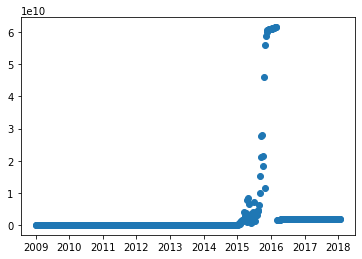

In [3]:
start_date = datetime.fromtimestamp(chain.blocks[0].timestamp).date()
end_date = datetime.strptime("2018-01-20", "%Y-%m-%d").date() #datetime.fromtimestamp(chain.blocks[-1].timestamp).date()
frequency = 7
cluster_list = [101080866]
chrono = SimpleChrono()

print(f'start_date is set as: {start_date}')
print(f'end_date is set as: {end_date}')    

datelist = daterange(start_date, end_date, by=frequency)
tqdm_bar = tqdm(datelist, desc="processed files")


x_values = []
y_values = []

# size = len(current_assets_zarr)
# print(f'size of current_assets_zarr={size}')

for timeunit in tqdm_bar:
    chrono.add_tic("net")
    current_assets_zarr = zarr.load(f'/local/scratch/exported/blockchain_parsed/bitcoin_darknet/gs_group/grayscale_op_ali/final/heur_1_data_v2/weekly/current_assets/current_assets_{timeunit}.zarr') #load gives an object array containing this dictionary:
    current_assets_zarr = dict(zip(current_assets_zarr["current_assets_index"], current_assets_zarr["current_assets_values"]))

    x_values.append(timeunit.strftime('%Y-%m-%d'))
    y_total = 0.0
    for cluster in cluster_list:
        if cluster in current_assets_zarr.keys():
            y_total = y_total + float(current_assets_zarr[cluster])
        else:
            y_total += 0.0

    y_values.append(y_total)
    # y_values.append(sum(current_assets_zarr.values())) for total

    tqdm_bar.set_description(f"week of '{timeunit.strftime('%Y-%m-%d')} took {chrono.elapsed('net')} sec", refresh=True)
    # print(sum(current_assets_zarr.values()))

with open(f'jsonResults/CA_{"101080866"}_2009-01-03_2018-01-20.json', 'w') as f:
    results_dict = dict(zip(x_values, y_values))
    save_json = json.dumps(results_dict)
    f.write(save_json)
    # print(save_json)

dates = matplotlib.dates.date2num(x_values)
plt.plot_date(dates, y_values)

# with open('result.txt', 'a') as fp:
#     fp.write(print(current_assets_zarr))

In [ ]:
# x_values2 = [timeunit.strftime('%Y-%m-%d') for timeunit in x_values]
# y_values2 = [float(value * 0.00000001) for value in y_values]

with open('jsonResults/CA_86826333_2009-01-03_2018-01-20.json', 'w') as f:
    results_dict = dict(zip(x_values, y_values))
    save_json = json.dumps(results_dict)
    f.write(save_json)
    print(save_json)



# Plotting results Grid for DNMs

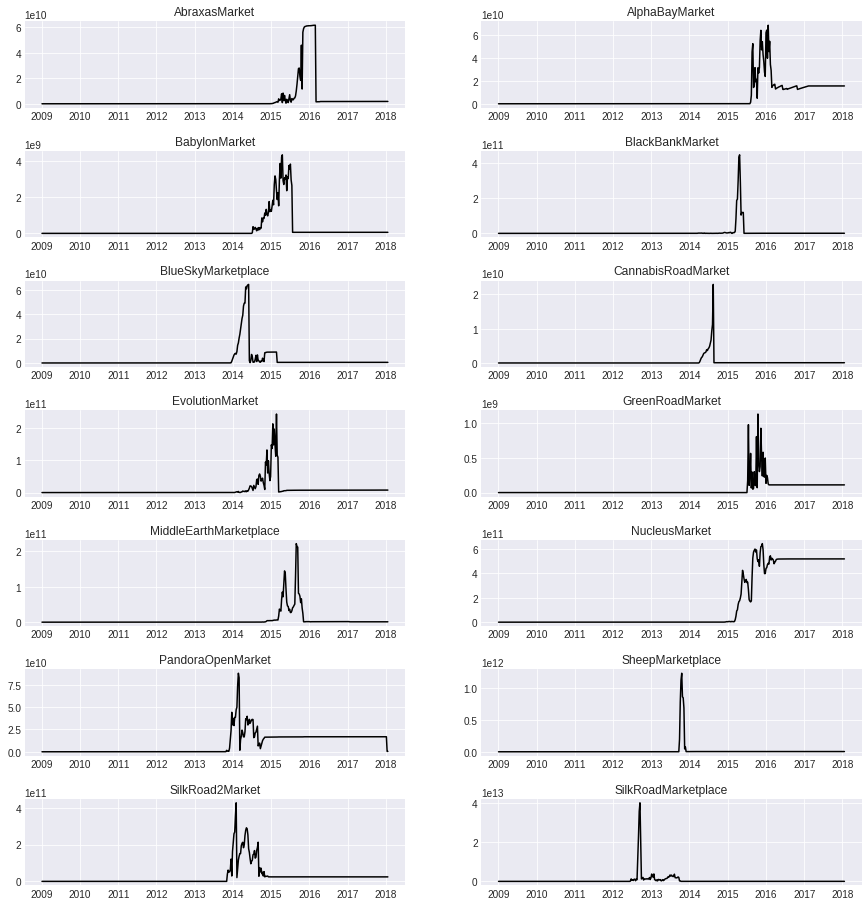

In [21]:
nameSwitcher = {101080866:"AbraxasMarket", 115726064:"AlphaBayMarket", 94998167:"BabylonMarket", 90613521:"BlackBankMarket", 88316586:"BlueSkyMarketplace", 92044383:"CannabisRoadMarket", 89576173:"EvolutionMarket", 112150330:"GreenRoadMarket", 
94494584:"MiddleEarthMarketplace", 99422262:"NucleusMarket", 86826333:"PandoraOpenMarket", 82285475:"SheepMarketplace", 87290351:"SilkRoad2Market", 79800777:"SilkRoadMarketplace"}

DNM_ids = [101080866, 115726064, 94998167, 90613521, 88316586, 92044383, 89576173, 112150330, 94494584, 99422262, 86826333, 82285475, 87290351, 79800777]

# x_values = []
# y_values = []

fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(15, 15))
fig.tight_layout()
plot_number = 1

for cluster_id in DNM_ids :
    x_values = []
    y_values = []
    with open(f'jsonResults/CA_{cluster_id}_2009-01-03_2018-01-20.json', 'r') as f:
        load_json = json.load(f)
        for iterator in load_json:
            x_values.append(iterator)
            y_values.append(float(load_json[iterator]))

        dates = matplotlib.dates.date2num(x_values)
        plt.subplot(7, 2, plot_number)
        plt.gca().set_title(nameSwitcher[cluster_id])
        plt.plot_date(dates, y_values, 'k-')
        plot_number += 1

# plt.figure(figsize=(185, 105))
# dates = matplotlib.dates.date2num(x_values)
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
plt.style.use('seaborn-darkgrid')
fig.savefig('graphs/test.png', dpi=100)
# plt.plot_date(dates, y_values, 'k-')




# Generating and plotting Dark ratio assortativity plot

start_date is set as: 2009-01-03
end_date is set as: 2018-01-20


week of '2018-01-20 took 163.576 sec: 100%|██████████| 473/473 [6:40:42<00:00, 50.83s/it]   


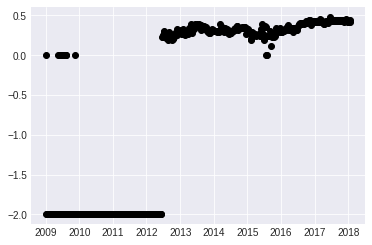

In [7]:
start_date = datetime.fromtimestamp(chain.blocks[0].timestamp).date()
end_date = datetime.strptime("2018-01-20", "%Y-%m-%d").date() #datetime.fromtimestamp(chain.blocks[-1].timestamp).date()
frequency = 7
chrono = SimpleChrono()

print(f'start_date is set as: {start_date}')
print(f'end_date is set as: {end_date}')    

datelist = daterange(start_date, end_date, by=frequency)
tqdm_bar = tqdm(datelist, desc="processed files")

x_values = []
y_values_assortativity = []

# size = len(current_assets_zarr)
# print(f'size of current_assets_zarr={size}')

for timeunit in tqdm_bar:
    chrono.add_tic("net")

    graph_location = f'/local/scratch/exported/blockchain_parsed/bitcoin_darknet/gs_group/grayscale_op_ali/final/heur_1_networks_v2_assortativity/week/{timeunit}.graphml.bz2' #load gives an object array containing this dictionary:
    g = nx.read_graphml(graph_location)
    
    x_values.append(timeunit.strftime('%Y-%m-%d'))
    y_values_assortativity.append(g.graph['DR_color_assortativity'])


    tqdm_bar.set_description(f"week of '{timeunit.strftime('%Y-%m-%d')} took {chrono.elapsed('net')} sec", refresh=True)
    # print(sum(current_assets_zarr.values()))

with open(f'jsonResults/assortativity_2009-01-03_2018-01-20.json', 'w') as f:
    results_dict = dict(zip(x_values, y_values_assortativity))
    save_json = json.dumps(results_dict)
    f.write(save_json)



dates = matplotlib.dates.date2num(x_values)
matplotlib.pyplot.style.use('seaborn-darkgrid')
matplotlib.pyplot.plot_date(dates, y_values_assortativity, color='black')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_132173/387240869.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "kx" (-> color='k'). The keyword argument will take precedence.
  matplotlib.pyplot.plot_date(dates, y_values, 'kx', color='black', linewidth=3)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


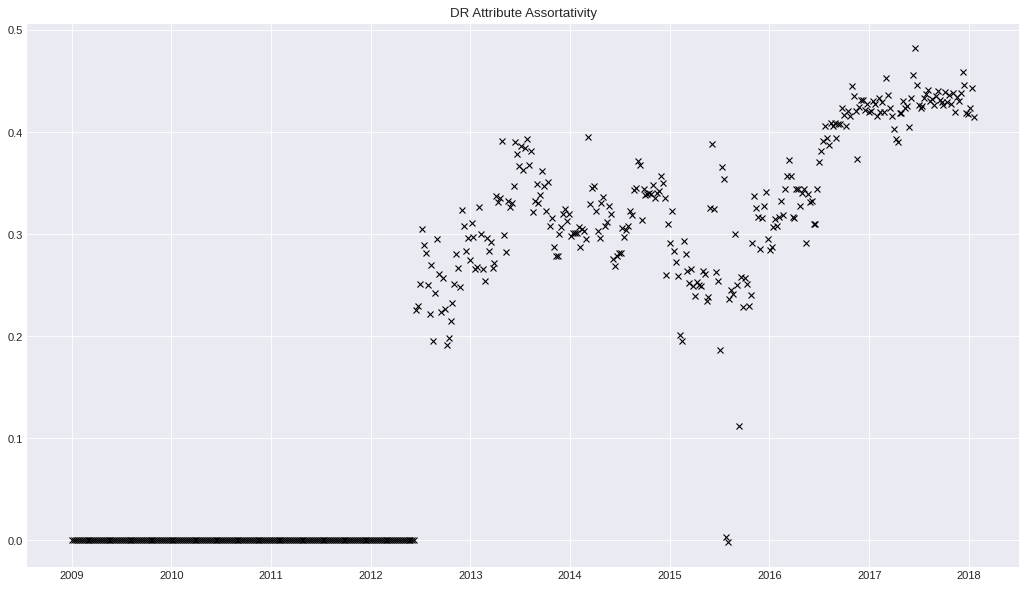

In [25]:
x_values = []
y_values = []
with open(f'jsonResults/assortativity_2009-01-03_2018-01-20.json', 'r') as f:
    load_json = json.load(f)
    for iterator in load_json:
        x_values.append(iterator)
        y_values.append(float(load_json[iterator]))

dates = matplotlib.dates.date2num(x_values)
matplotlib.pyplot.figure(figsize=(16, 9), dpi=80)
matplotlib.pyplot.style.use('seaborn-darkgrid')
matplotlib.pyplot.legend(loc="upper left")
matplotlib.pyplot.plot_date(dates, y_values, 'kx', color='black', linewidth=3)
matplotlib.pyplot.legend()
matplotlib.pyplot.gca().set_title("DR Attribute Assortativity")
matplotlib.pyplot.savefig('graphs/assortativity_plot.png', dpi=100)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_265649/843812623.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  matplotlib.pyplot.plot_date(dates, y_values, 'k-', color='green', linewidth=3, label="Total Circulating Satoshis")


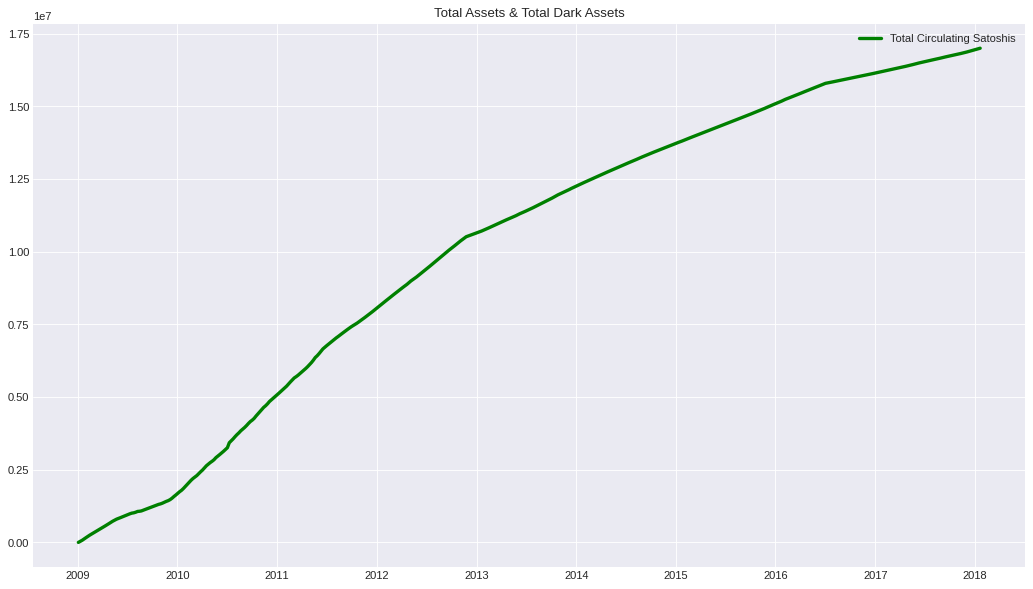

In [7]:
x_values = []
y_values = []
y_values_DA = []

with open(f'jsonResults_v3/Total_CA_2009-01-03_2018-01-20.json', 'r') as f:
    load_json = json.load(f)
    for iterator in load_json:
        x_values.append(iterator)
        y_values.append(float(load_json[iterator]))

with open(f'jsonResults/Total_DA_2009-01-03_2018-01-20.json', 'r') as f:
    load_json = json.load(f)
    for iterator in load_json:
        y_values_DA.append(float(load_json[iterator]))

dates = matplotlib.dates.date2num(x_values)
matplotlib.pyplot.figure(figsize=(16, 9), dpi=80)
matplotlib.pyplot.style.use('seaborn-darkgrid')
matplotlib.pyplot.legend(loc="upper left")
matplotlib.pyplot.plot_date(dates, y_values, 'k-', color='green', linewidth=3, label="Total Circulating Satoshis")
# matplotlib.pyplot.plot_date(dates, y_values_DA, 'k-', color='black', linewidth=3, label="Total Circulating Dark Satoshis")
matplotlib.pyplot.legend()
matplotlib.pyplot.gca().set_title("Total Assets & Total Dark Assets")
matplotlib.pyplot.savefig('graphs/TotalAssets_plot.png', dpi=100)

# Generating and plotting Dark ratio plots

start_date is set as: 2009-01-03
end_date is set as: 2018-01-20


week of '2018-01-20 took 191.581 sec: 100%|██████████| 473/473 [4:04:26<00:00, 31.01s/it]   


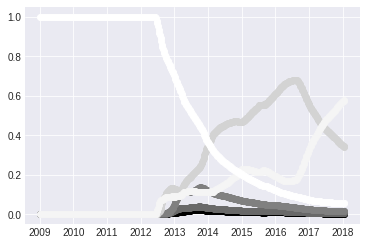

In [4]:
start_date = datetime.fromtimestamp(chain.blocks[0].timestamp).date()
end_date = datetime.strptime("2018-01-20", "%Y-%m-%d").date() #datetime.fromtimestamp(chain.blocks[-1].timestamp).date()
frequency = 7
chrono = SimpleChrono()

print(f'start_date is set as: {start_date}')
print(f'end_date is set as: {end_date}')    

datelist = daterange(start_date, end_date, by=frequency)
tqdm_bar = tqdm(datelist, desc="processed files")


x_values = []
y_values_black = []
y_values_dark_grey = []
y_values_grey = []
y_values_light_grey = []
y_values_greyish_white = []
y_values_white = []

# size = len(current_assets_zarr)
# print(f'size of current_assets_zarr={size}')

for timeunit in tqdm_bar:
    chrono.add_tic("net")

    count_black = 0
    count_dark_grey = 0
    count_grey = 0
    count_light_grey = 0
    count_greyish_white = 0
    count_white = 0

    dark_ratio_zarr = zarr.load(f'/local/scratch/exported/blockchain_parsed/bitcoin_darknet/gs_group/grayscale_op_ali/final/heur_1_data_v3/weekly/dark_ratio/dark_ratio_{timeunit}.zarr') #load gives an object array containing this dictionary:
    dark_ratio_zarr = dict(zip(dark_ratio_zarr["dark_ratio_index"], dark_ratio_zarr["dark_ratio_values"]))

    size = len(dark_ratio_zarr)

    for v in dark_ratio_zarr.values():
        if v == 1.0:
            count_black += 1
        elif 0.75 <= v < 1.0 :
            count_dark_grey += 1
        elif 0.5 <= v < 0.75 :
            count_grey += 1
        elif 0.25 <= v < 0.5 :
            count_light_grey += 1
        elif 0 < v < 0.25 :
            count_greyish_white += 1
        elif v == 0.0 :
            count_white += 1
    
    x_values.append(timeunit.strftime('%Y-%m-%d'))
    y_values_black.append(count_black / size)
    y_values_dark_grey.append(count_dark_grey / size)
    y_values_grey.append(count_grey / size)
    y_values_light_grey.append(count_light_grey / size)
    y_values_greyish_white.append(count_greyish_white / size)
    y_values_white.append(count_white / size)

    tqdm_bar.set_description(f"week of '{timeunit.strftime('%Y-%m-%d')} took {chrono.elapsed('net')} sec", refresh=True)
    # print(sum(current_assets_zarr.values()))

with open(f'jsonResults_v3/DR_black_2009-01-03_2018-01-20.json', 'w') as f:
    results_dict = dict(zip(x_values, y_values_black))
    save_json = json.dumps(results_dict)
    f.write(save_json)

with open(f'jsonResults_v3/DR_dark_grey_2009-01-03_2018-01-20.json', 'w') as f:
    results_dict = dict(zip(x_values, y_values_dark_grey))
    save_json = json.dumps(results_dict)
    f.write(save_json)

with open(f'jsonResults_v3/DR_grey_2009-01-03_2018-01-20.json', 'w') as f:
    results_dict = dict(zip(x_values, y_values_grey))
    save_json = json.dumps(results_dict)
    f.write(save_json)

with open(f'jsonResults_v3/DR_light_grey_2009-01-03_2018-01-20.json', 'w') as f:
    results_dict = dict(zip(x_values, y_values_light_grey))
    save_json = json.dumps(results_dict)
    f.write(save_json)

with open(f'jsonResults_v3/DR_greyish_white_2009-01-03_2018-01-20.json', 'w') as f:
    results_dict = dict(zip(x_values, y_values_greyish_white))
    save_json = json.dumps(results_dict)
    f.write(save_json)

with open(f'jsonResults_v3/DR_white_2009-01-03_2018-01-20.json', 'w') as f:
    results_dict = dict(zip(x_values, y_values_white))
    save_json = json.dumps(results_dict)
    f.write(save_json)


dates = matplotlib.dates.date2num(x_values)
matplotlib.pyplot.style.use('seaborn-darkgrid')
matplotlib.pyplot.plot_date(dates, y_values_black, color='black')
matplotlib.pyplot.plot_date(dates, y_values_dark_grey, color='dimgray')
matplotlib.pyplot.plot_date(dates, y_values_grey, color='gray')
matplotlib.pyplot.plot_date(dates, y_values_light_grey, color='lightgray')
matplotlib.pyplot.plot_date(dates, y_values_greyish_white, color='whitesmoke')
matplotlib.pyplot.plot_date(dates, y_values_white, color='white')